<a href="https://colab.research.google.com/github/ssooni/data_mining_practice/blob/master/dust_weather/dust_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Íµ¨Í∏Ä ÎìúÎùºÏù¥Î∏å ÎßàÏö¥Ìä∏ 
Ï†ú Í∞úÏù∏ ÎìúÎùºÏù¥Î∏åÏóê ÏûàÎäî Î∂ÄÎ∂ÑÏù¥Îùº ÏïÑÎûò Î∂ÄÎ∂ÑÏùÄ Ïã§ÌñâÌï¥ÎèÑ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏùÄ ÏóÜÏäµÎãàÎã§.

In [3]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/dataset', force_remount=True)

Mounted at /dataset


In [33]:
!ls -la /dataset/MyDrive/dust/
!pip install --upgrade tables

total 1622388
-rw------- 1 root root    2439292 Jan  5 22:44 'best_model (1).pt'
-rw------- 1 root root    2439291 Jan  5 03:42  best_model.pt
-rw------- 1 root root 1655826560 Jul  8  2019  data.hdf
-rw------- 1 root root     618368 Mar  4 10:43  seoul_municipalities.shp
Requirement already up-to-date: tables in /usr/local/lib/python3.7/dist-packages (3.6.1)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import os

from sklearn.preprocessing import MinMaxScaler

BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

SEED = 5
random.seed(SEED)
torch.manual_seed(SEED)

print("cpuÏôÄ cuda Ï§ë Îã§Ïùå Í∏∞Í∏∞Î°ú ÌïôÏäµÌï®:", DEVICE)

cpuÏôÄ cuda Ï§ë Îã§Ïùå Í∏∞Í∏∞Î°ú ÌïôÏäµÌï®: cuda


## Îç∞Ïù¥ÌÑ∞
Îç∞Ïù¥ÌÑ∞Îäî 2009.01.01 ~ 2019.01.01 ÏÇ¨Ïù¥Ïùò ÏÑúÏö∏ ÎÇ†Ïî®ÏôÄ ÏÑúÏö∏ÏãúÎÇ¥ Íµ¨ Î≥ÑÎ°ú ÏÑ§ÏπòÎêú ÎØ∏ÏÑ∏Î®ºÏßÄ Ï∏°Ï†ï Îç∞Ïù¥ÌÑ∞Ïù¥Îã§.  
ÎØ∏ÏÑ∏Î®ºÏßÄ Ï∏°Ï†ï Îç∞Ïù¥ÌÑ∞ÏôÄ Í∏∞ÏÉÅ Îç∞Ïù¥ÌÑ∞Î•º Í∞ÅÍ∞Å apiÎ•º ÌÜµÌï¥ÏÑú 10ÎÖÑÏπòÎ•º ÏàòÏßë ÌõÑ hdf ÌååÏùºÎ°ú Ï†ÄÏû•ÌïòÏòÄÏúºÎ©∞, Í∑∏ Í≥ºÏ†ïÏùÄ Ïù¥Î≤à ÏÜåÏä§ ÏΩîÎìúÏóêÏÑú Ï†úÏô∏ÌïòÏòÄÎã§.  
Í∏∞ÏÉÅ Îç∞Ïù¥ÌÑ∞ Ìï≠Î™© Ï§ëÏóêÎäî ÏäµÎèÑ, Ïò®ÎèÑ, ÌíçÏÜç, ÌêÅÌñ•, Í∏∞ÏïïÏùÑ ÏÇ¨Ïö©ÌïòÏòÄÏúºÎ©∞, ÎØ∏ÏÑ∏Î®ºÏßÄÎÜçÎèÑÎäî PM2.5 ÏàòÏπòÎ•º ÏÇ¨Ïö©ÌïòÏòÄÎã§.


*Îç∞Ïù¥ÌÑ∞ Ï∂úÏ≤ò : Í≥µÍ≥µÎç∞Ïù¥ÌÑ∞Ìè¨ÌÑ∏*


In [6]:
import pandas as pd
import numpy as np

master = pd.read_hdf("/dataset/MyDrive/dust/data.hdf", "master", mode='r')

master = master.sort_index()

X_label = ['HM', 'PA', 'PS', 'PV','TA', 'TD', 'TS', 'WD', 'WS'] # ÏäµÎèÑ, ÎåÄÍ∏∞Ïïï, 
y_label = ['PM25']

master[X_label + y_label].head()

HM      PA      PS   PV   TA    TD    TS     WD   WS  PM25
2009-01-01  55.0  1013.7  1024.9  1.9 -7.6 -15.0 -10.1  290.0  2.1  14.0
2009-01-01  55.0  1013.7  1024.9  1.9 -7.6 -15.0 -10.1  290.0  2.1  13.0
2009-01-01  55.0  1013.7  1024.9  1.9 -7.6 -15.0 -10.1  290.0  2.1  12.0
2009-01-01  55.0  1013.7  1024.9  1.9 -7.6 -15.0 -10.1  290.0  2.1  18.0
2009-01-01  55.0  1013.7  1024.9  1.9 -7.6 -15.0 -10.1  290.0  2.1  19.0

In [7]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style('whitegrid')

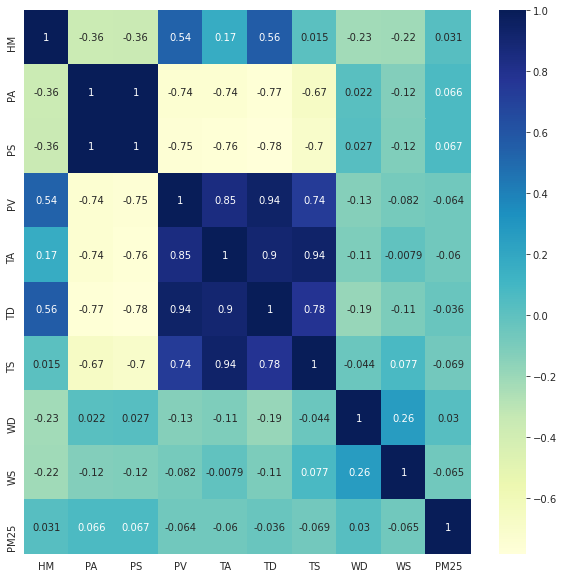

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(master[X_label + y_label].corr(), annot=True, cmap='YlGnBu')

## Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Î∞è ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
1. ÎàÑÎùΩÎêú Îç∞Ïù¥ÌÑ∞   
ÎØ∏ÏÑ∏Î®ºÏßÄ Îç∞Ïù¥ÌÑ∞Ïùò ÎàÑÎùΩÏù¥ ÏûàÎäî Îç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÎã§. NanÏúºÎ°ú ÎêòÏñ¥ ÏûàÎäî Îç∞Ïù¥ÌÑ∞Îäî ÌïôÏäµ Í≤∞Í≥ºÏóê ÏòÅÌñ•ÏùÑ Ï§Ñ Ïàò ÏûàÍ∏∞ ÎñÑÎ¨∏Ïóê Î∞òÎìúÏãú Ï≤òÎ¶¨Ìï¥Ïïº ÌïòÎ©∞,  
Ïù¥Ï†Ñ ÏãúÍ∞ÑÏóê Ï∏°Ï†ïÎêú Îç∞Ïù¥ÌÑ∞Î•º Ï±ÑÏö∞Îäî Î∞©ÏãùÏùÑ ÏÇ¨Ïö©ÌñàÎã§.

2. Normalization  
Í∏∞Ïïï, ÏäµÎèÑ, Ïò®ÎèÑ Îì±ÏùÄ Í∞ÅÍ∞Å Ï∏°Ï†ïÌïòÎäî Îã®ÏúÑÍ∞Ä Îã§Î•¥Í≥† Îß§ ÏãúÍ∞Ñ Î≥ÄÌôîÌïòÎäî ÌÅ¨Í∏∞ÎèÑ Îã§Î•¥Îã§.  
Ïù¥Îü¨Ìïú Ï∞®Ïù¥ Ïó≠Ïãú ÌïôÏäµÏóê ÏòÅÌñ•ÏùÑ Ï§Ñ Ïàò ÏûàÎäî Î∂ÄÎ∂ÑÏù¥ÎØÄÎ°ú Min-Max SacaleÏùÑ Ìï¥ÏÑú 0~1 ÏÇ¨Ïù¥Ïùò Í∞íÏúºÎ°ú Î≥ÄÍ≤ΩÌïúÎã§. 

3. Í∑∏ Ïô∏  
ÏÑúÏö∏Ïãú Í∞ïÎÇ®Ïùò Îç∞Ïù¥ÌÑ∞Îßå ÏÇ¨Ïö©ÌïòÏòÄÎã§.  
ColabÏùò ÏÇ¨Ïö© Í∞ÄÎä•Ìïú RAM Ï†úÌïúÏùÑ ÎÑòÏñ¥Î≤ÑÎ¶¨Îäî Î∞îÎûåÏóê 30000Í±¥ Ï†ïÎèÑÎßå Î™®Îç∏ÎßÅ ÌïòÎäîÎç∞ ÏÇ¨Ïö©ÎêòÏóàÎã§.  
Î∞∞Ïπò Î∞©ÏãùÏúºÎ°ú Î≥ÄÍ≤ΩÌïòÎ©¥ Îû®ÏùÑ Ï°∞Í∏à Îçú Ïì∏ Ïàò ÏûàÎã§.   
ÌïôÏäµ : ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò ÎπÑÏú®ÏùÄ 9:1Î°ú ÌïòÏòÄÎã§.  
Slide Window = 20 ÏúºÎ°ú ÌïôÏäµÎç∞Ïù¥ÌÑ∞Î•º Ïû¨Íµ¨ÏÑ±ÌïòÏòÄÎã§.

In [17]:
sample = master[master["MSRSTE_NM"]== "Í∞ïÎÇ®Íµ¨"][X_label + y_label] # ÏÑúÏö∏Ïãú Í∞ïÎÇ®Íµ¨Ïùò Îç∞Ïù¥ÌÑ∞Îßå ÏÇ¨Ïö©
sample = sample.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
for l in X_label:
   sample[l] = scaler.fit_transform(sample[l].values.reshape(-1,1))

### Ïù¥ÏÉÅÏπò Ï≤òÎ¶¨
PM2.5 ÎØ∏ÏÑ∏Î®ºÏßÄ ÎÜçÎèÑÏùò Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨Î•º ÌôïÏù∏ ÌïòÍ∏∞ ÏúÑÌï¥ Î∞ÄÎèÑ Ìï®ÏàòÎ°ú Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨Î•º ÌôïÏù∏ Ìï¥Î≥¥ÏïòÎã§.  
200Ïù¥ ÎÑòÎäî Ï†ÅÏùÄ ÏàòÏùò Îç∞Ïù¥ÌÑ∞Í∞Ä ÏûàÎäîÎç∞, ÏÉÅÏúÑ 0.5ÌîÑÎ°úÎ•º Ï∞®ÏßÄÌïòÎäî Îç∞Ïù¥ÌÑ∞Î•º Ïù¥ÏÉÅÏπòÎ°ú ÌïòÍ≥† Ï†úÍ±∞ÌïòÎäî ÏûëÏóÖÏùÑ ÌïòÏòÄÎã§. 

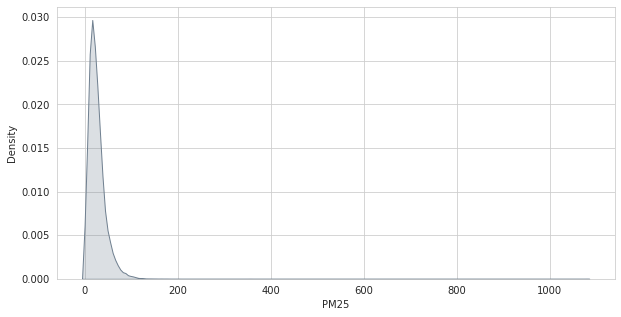

In [11]:
plt.figure(figsize=(10,5))
sns.kdeplot(x='PM25', data=sample[['PM25']], fill=True, color='slategray');

outliner :  99.0
339 / 69280


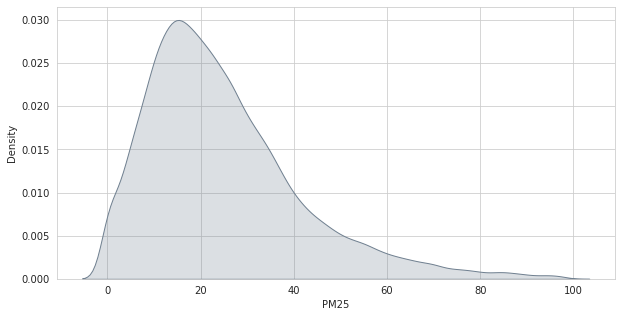

In [29]:
outliner = sample['PM25'].quantile(0.995)
print("outliner : ",  outliner)
print(sample[sample['PM25'] > outliner].shape[0], "/", sample.shape[0])
plt.figure(figsize=(10,5))
sns.kdeplot(x='PM25', data=sample[sample['PM25'] < outliner][['PM25']], fill=True, color='slategray');

In [19]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

def split_data(raw_data, lookback,batch_size=2, outliner=None, target="PM25"):
  data = []

  if outliner is not None:
    # Ïù¥ÏÉÅÏπò ÎØ∏Îßå Îç∞Ïù¥ÌÑ∞Îßå ÏÇ¨Ïö©
    raw_data2 = raw_data[raw_data[target] < outliner]
    data_raw = raw_data2.to_numpy() 
  else:
    data_raw = raw_data.to_numpy()

  y = np.reshape(data_raw[:, -1], (-1, 1))

  # create all possible sequences of length seq_len
  for index in range(len(data_raw) - lookback): 
      data.append(data_raw[index: index + lookback])
  
  data = np.array(data);
  test_set_size = int(np.round(0.1 * data.shape[0]));
  train_set_size = data.shape[0] - (test_set_size);
  
  x_train = torch.from_numpy(data[:train_set_size, :, :-1]).type(torch.Tensor)
  y_train = torch.from_numpy(y[lookback:train_set_size+lookback, :]).type(torch.Tensor)
  
  x_test = torch.from_numpy(data[train_set_size: , :, :-1]).type(torch.Tensor)
  y_test = torch.from_numpy(y[train_set_size+lookback:, :]).type(torch.Tensor)
  
  train_set = TensorDataset(x_train, y_train)
  test_set = TensorDataset(x_train, y_train)

  dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  dataloader2 = DataLoader(test_set, batch_size=batch_size, shuffle=True)

  return x_train, y_train, x_test, y_test, dataloader, dataloader2

In [20]:
x_train, y_train, x_test, y_test, dataloader, dataloader2 = split_data(sample, 20, 32, outliner=outliner)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([62008, 20, 9]) torch.Size([6890, 20, 9])
torch.Size([62008, 1]) torch.Size([6890, 1])


## GRU
Sequance ModelÏùò Ìïú Ï¢ÖÎ•òÎ°ú LSTMÏùò Í∞ÑÏÜåÌôîÎêú Î≤ÑÏ†ÑÏúºÎ°ú ÏïåÎ†§Ï†∏ ÏûàÎã§.  


In [21]:
class GRU(nn.Module):
  def __init__(self, n_layers, hidden_dim, input_dim, n_classes=1, dropout_p=0.2):
      super(GRU, self).__init__()
      self.n_layers = n_layers
      self.hidden_dim = hidden_dim

      self.dropout = nn.Dropout(dropout_p)
      self.gru = nn.GRU(input_dim, self.hidden_dim, num_layers=self.n_layers, batch_first=True, dropout=dropout_p)
      self.fc = nn.Linear(self.hidden_dim, n_classes)

  def forward(self, x):
      h0 = self._init_state(x.size(0))
      out, (hn) = self.gru(x, (h0.detach()))
      out = self.fc(out[:, -1, :]) 
      return out

  def _init_state(self, batch_size=1):
      weight = next(self.parameters()).data
      return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(DEVICE)

## ÌïôÏäµ / ÌÖåÏä§Ìä∏ Í≤∞Í≥º
- 10000Ìöå Î∞òÎ≥µ ÌïôÏäµÌïòÎ©¥ÏÑú LossÏùò Í∞êÏÜåÎ•º ÌôïÏù∏.  
- LossÎäî Mean Square ErrorÎ•º ÏÇ¨Ïö©Ìï¥ÏÑú Ï∏°Ï†ï.  
- OptimiserÎäî AdamÏùÑ ÏÇ¨Ïö©ÌïòÏòÄÏùå



In [23]:
def evaluate(model, val_iter):
  model.eval()
  corrects, total_loss = 0, 0
  
  for batch in val_iter:
    x, y = batch
    y_p = model(x.to(DEVICE))
    loss = torch.nn.MSELoss(reduction='mean')(y_p, y.to(DEVICE))
    total_loss += loss.item()

  size = len(val_iter)
  avg_loss = total_loss / size
  return avg_loss

In [24]:
import time
import numpy

num_epochs = 100
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

model = GRU(input_dim=len(X_label), hidden_dim=256, n_classes=1, n_layers=1).to(DEVICE)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
torch.cuda.empty_cache()
best_val_loss = None
for t in range(num_epochs):
  model.train()
  for batch_idx, samples in enumerate(dataloader):
    x, y = samples

    y_train_pred = model(x.to(DEVICE))
    # print("pridiction: ", y_train_pred[:10, :], "\n Real: ", y_train[:10])
    optimizer.zero_grad()
    loss = criterion(y_train_pred, y.to(DEVICE))
    
    loss.backward()
    optimizer.step()

  avg_loss = evaluate(model, dataloader2)

  if not best_val_loss or avg_loss < best_val_loss:
      if not os.path.isdir("snapshot"):
          os.makedirs("snapshot")
      torch.save(model.state_dict(), './snapshot/best_model.pt')
 
  if t % 20 == 0:
    print("Epoch ", t, "MSE: ", avg_loss)
  hist[t] = avg_loss

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch  0 MSE:  236.50815087427665
Epoch  20 MSE:  65.32919089196267
Epoch  40 MSE:  34.29731462516037
Epoch  60 MSE:  27.84397556808834
Epoch  80 MSE:  20.73988640763565
Training time: 742.5226194858551


### Learning rate check / ÌïôÏäµ Í≤∞Í≥º ÌôïÏù∏
LossÍ∞Ä Í∞êÏÜåÌïòÎäî ÏñëÏÉÅÏùÑ ÌôïÏù∏ ÌïòÏòÄÎã§. ÍµêÍ≥ºÏÑúÏóê ÎÇòÏò§Îäî Ï†ïÏÑùÏ†ÅÏù∏ Î™®ÏñëÏù¥Îùº ÎßåÏ°±!! üòä  
ÌïôÏäµÎêú Î™®Îç∏ÏùÑ Í∏∞Î∞òÏúºÎ°ú ÏòàÏ∏° Í∞íÍ≥º Ïã§Ï†ú Í∞íÏùÑ ÎπÑÍµêÎèÑ Ìï¥Î≥¥ÏïòÎã§. 

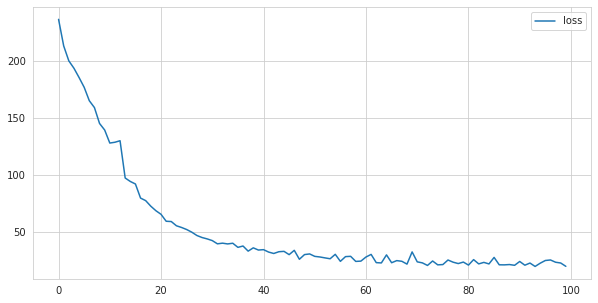

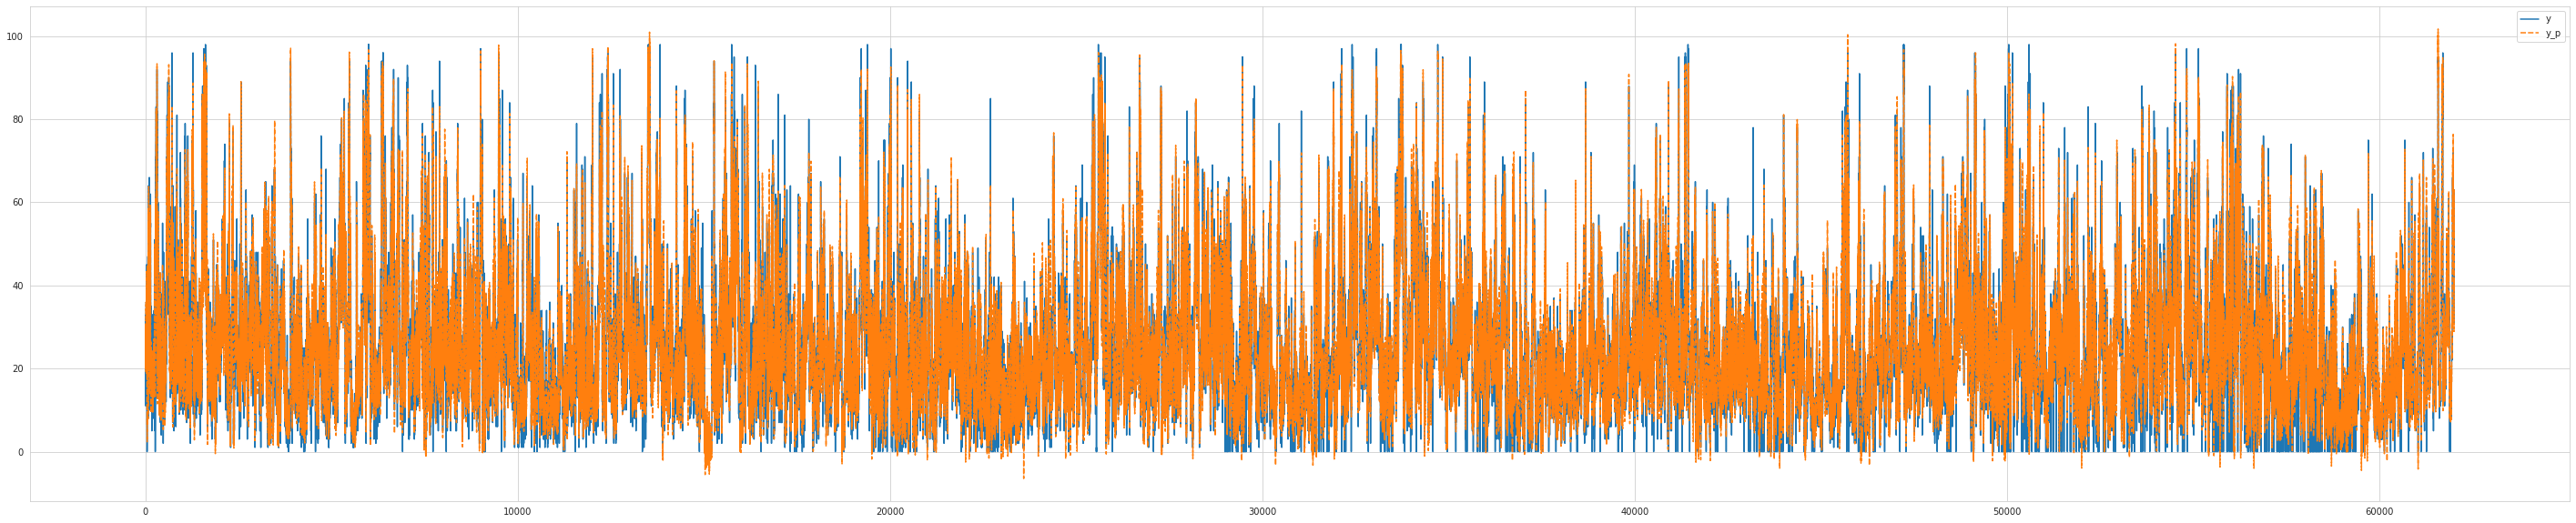

In [31]:
%matplotlib inline
import matplotlib.pylab as plt

plt.figure(figsize=(10,5))
sns.lineplot(data=pd.DataFrame(hist, columns=["loss"]))

model.eval()
prediction = model(x_train.to(DEVICE)) 
a = pd.DataFrame(y_train.view(-1), columns=["y"])
a["y_p"] = pd.Series(prediction.view(-1).cpu().detach().numpy())
plt.figure(figsize=(50,10))
sns.lineplot(data=a)

### ÌïôÏäµÍ≤∞Í≥º 
Ïñ¥Îäê Ï†ïÎèÑ Ï∂îÏÑ∏Îäî ÎßûÏ∂îÎäî ÎìØ ÌïòÎäîÎç∞, Ïã§Ï†úÏôÄ Ï∞®Ïù¥Í∞Ä ÎßéÏù¥ ÎÇòÎäî Íµ¨Í∞ÑÏù¥ ÏûàÎã§.  
1. ÎØ∏ÏÑ∏Î®ºÏßÄ Îç∞Ïù¥ÌÑ∞Î•º Î¥§ÏùÑ Îïå Ìïú Î≤àÏî© Ï£ºÎ≥Ä ÏãúÍ∞Ñ Îç∞Ïù¥ÌÑ∞Ïóê ÎπÑÌï¥ Í∞íÏù¥ ÌÅ¨Í≤å Î≥ÄÌôîÌïòÎäî Í≤ΩÏö∞Í∞Ä ÏûàÎäîÎç∞,  
Ìï¥Îãπ ÎèÑÎ©îÏù∏Ïùò ÏßÄÏãùÏù¥ ÏóÜÏñ¥ÏÑú Ìï¥Îãπ Î∂ÄÎ∂ÑÏóê ÎåÄÌïú Ï†ÑÏ≤òÎ¶¨Í∞Ä ÎêòÏßÄ ÏïäÏùÄ Í≤ÉÏù¥ ÏòÅÌñ•ÏùÑ Ï§Ä Í±∞ Í∞ôÎã§.
2. Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞Î•º ÏÇ¨Ïö©Ìï† Ïàò ÏûàÍ≤å ÏµúÏ†ÅÌôîÎ•º ÏãúÎèÑÌï¥ÏÑú ÌïôÏäµÏùÑ ÌïúÎã§.   
3. ÏÉàÎ°úÏö¥ FeatureÎ•º Ï∂îÍ∞ÄÌï¥ Î≥¥Îäî Í≤ÉÎèÑ Í≥†ÎØºÌï¥Î≥¥Ïûê.  
Ïòà) Í∞ïÎÇ®Íµ¨ Ï£ºÎ≥ÄÏùò ÎØ∏ÏÑ∏Î®ºÏßÄ Îç∞Ïù¥ÌÑ∞Î•º FeatureÎ°ú ÏÇ¨Ïö©. 

(6890,)


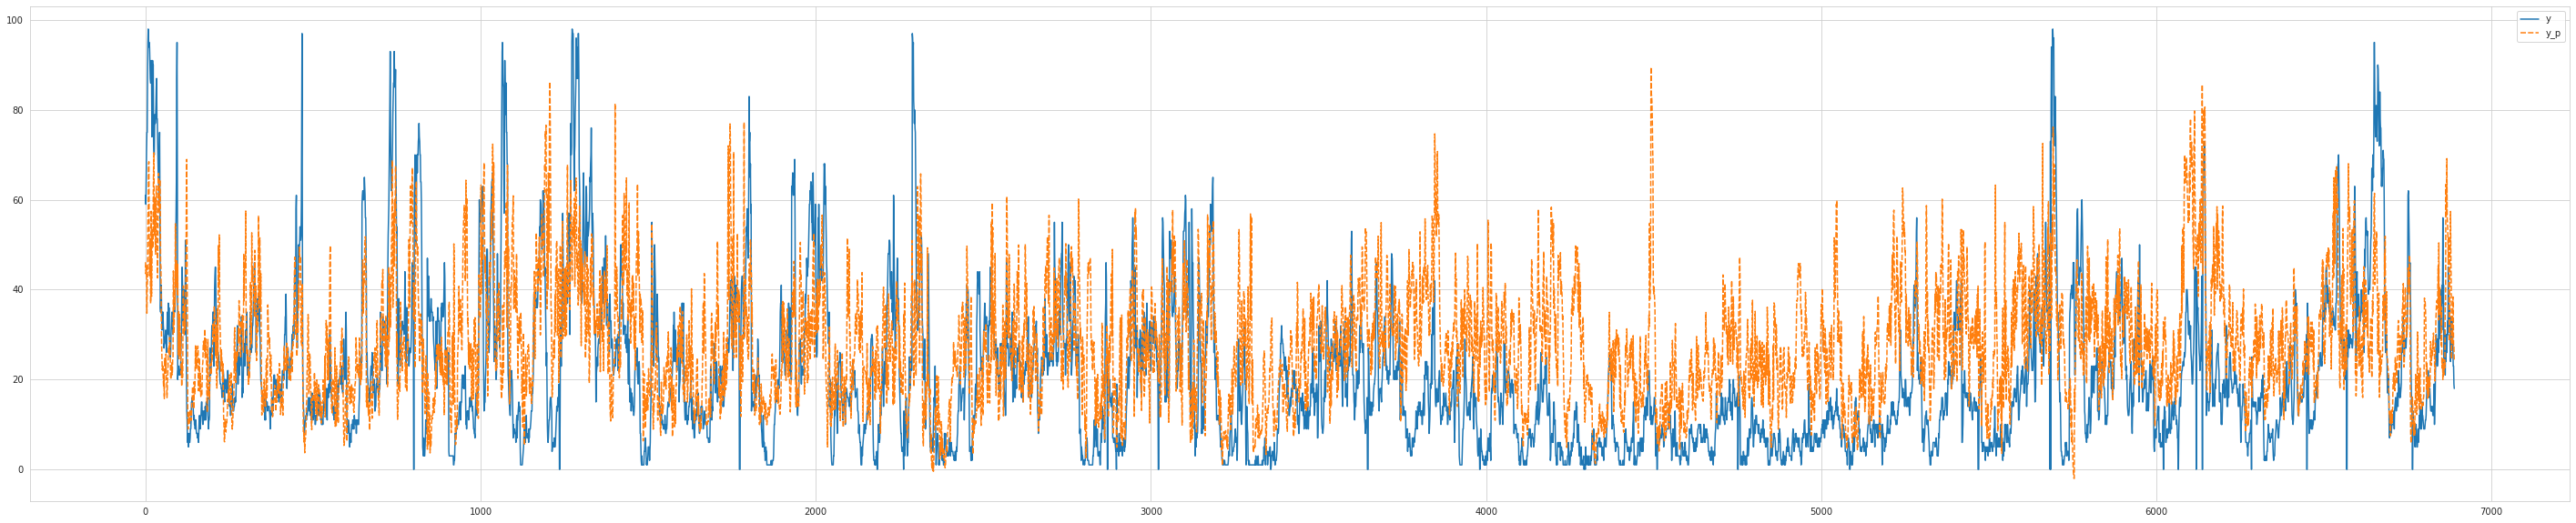

In [30]:
model.load_state_dict(torch.load('./snapshot/best_model.pt'))
model.eval()
prediction = model(x_test.to(DEVICE)) 
print(prediction.view(-1).cpu().detach().numpy().shape)
a = pd.DataFrame(y_test.view(-1), columns=["y"])
a["y_p"] = pd.Series(prediction.view(-1).cpu().detach().numpy())

plt.figure(figsize=(50,10))
sns.lineplot(data=a)

https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f


In [47]:
## ÏßÄÎèÑÎ•º Ï∂îÏ∂ú
!pip install pyshp

total 1622408
-rw------- 1 root root    2439292 Jan  5 22:44 'best_model (1).pt'
-rw------- 1 root root    2439291 Jan  5 03:42  best_model.pt
-rw------- 1 root root 1655826560 Jul  8  2019  data.hdf
-rw------- 1 root root      20499 Mar  3 16:00  LARD_ADM_SECT_SGG_11.dbf
-rw------- 1 root root     618368 Mar  4 10:43  seoul_municipalities.shp


In [48]:
!ls -la /dataset/MyDrive/dust/

total 1622893
-rw------- 1 root root    2439292 Jan  5 22:44 'best_model (1).pt'
-rw------- 1 root root    2439291 Jan  5 03:42  best_model.pt
-rw------- 1 root root 1655826560 Jul  8  2019  data.hdf
-rw------- 1 root root      20499 Mar  3 16:00  LARD_ADM_SECT_SGG_11.dbf
-rw------- 1 root root        761 Mar  3 16:00  LARD_ADM_SECT_SGG_11.prj
-rw------- 1 root root     494976 Mar  3 16:00  LARD_ADM_SECT_SGG_11.shp
-rw------- 1 root root        308 Mar  3 16:00  LARD_ADM_SECT_SGG_11.shx
-rw------- 1 root root     618368 Mar  4 10:43  seoul_municipalities.shp


In [59]:
import shapefile as shp
shp_path = "/dataset/MyDrive/dust/LARD_ADM_SECT_SGG_11.shp"
sf = shp.Reader(shp_path,encoding='MS949')
sf.records()

[Record #0: ['11200', 'ÏÑ±ÎèôÍµ¨', 49, '11200', 260],
 Record #1: ['11215', 'Í¥ëÏßÑÍµ¨', 49, '11215', 292],
 Record #2: ['11740', 'Í∞ïÎèôÍµ¨', 337, '11740', 127],
 Record #3: ['11710', 'ÏÜ°ÌååÍµ¨', 1969, '11710', 128],
 Record #4: ['11680', 'Í∞ïÎÇ®Íµ¨', 33, '11680', 129],
 Record #5: ['11650', 'ÏÑúÏ¥àÍµ¨', 33, '11650', 130],
 Record #6: ['11620', 'Í¥ÄÏïÖÍµ¨', 33, '11620', 131],
 Record #7: ['11590', 'ÎèôÏûëÍµ¨', 689, '11590', 132],
 Record #8: ['11560', 'ÏòÅÎì±Ìè¨Íµ¨', 481, '11560', 133],
 Record #9: ['11545', 'Í∏àÏ≤úÍµ¨', 33, '11545', 134],
 Record #10: ['11530', 'Íµ¨Î°úÍµ¨', 33, '11530', 135],
 Record #11: ['11500', 'Í∞ïÏÑúÍµ¨', 65, '11500', 136],
 Record #12: ['11470', 'ÏñëÏ≤úÍµ¨', 337, '11470', 137],
 Record #13: ['11440', 'ÎßàÌè¨Íµ¨', 673, '11440', 138],
 Record #14: ['11410', 'ÏÑúÎåÄÎ¨∏Íµ¨', 1025, '11410', 139],
 Record #15: ['11380', 'ÏùÄÌèâÍµ¨', 33, '11380', 140],
 Record #16: ['11350', 'ÏÑúÏö∏ÏãúÎÖ∏ÏõêÍµ¨', 33, '11350', 141],
 Record #17: ['11320', 'ÏÑúÏö∏ÏãúÎèÑÎ¥âÍµ¨', 33, '1

In [63]:
sf.shapeRecords()[1]

In [58]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

df = read_shapefile(sf)
df.sample(5)

ADM_SECT_C SGG_NM  ...  GID                                             coords
11      11500    Í∞ïÏÑúÍµ¨  ...  136  [(935035.24891426, 1950923.29359167), (935041....
22      11215    Í¥ëÏßÑÍµ¨  ...  147  [(962617.046201297, 1947108.13061675), (962385...
13      11440    ÎßàÌè¨Íµ¨  ...  138  [(942921.892141231, 1952686.94949072), (942923...
3       11710    ÏÜ°ÌååÍµ¨  ...  128  [(968640.372298973, 1944982.49182513), (968640...
25      11110    Ï¢ÖÎ°úÍµ¨  ...  150  [(953559.700663715, 1959304.5874816), (953628....

[5 rows x 6 columns]

In [56]:
def plot_shape(id, s=None):
    """ PLOTS A SINGLE SHAPE """
    plt.figure()
    ax = plt.axes()
    ax.set_aspect('equal')
    shape_ex = sf.shape(id)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    plt.plot(x_lon,y_lat) 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)
    plt.text(x0, y0, s, fontsize=10)
    # use bbox (bounding box) to set plot limits
    plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])
    return x0, y0

def plot_map(sf, x_lim = None, y_lim = None, figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)
        

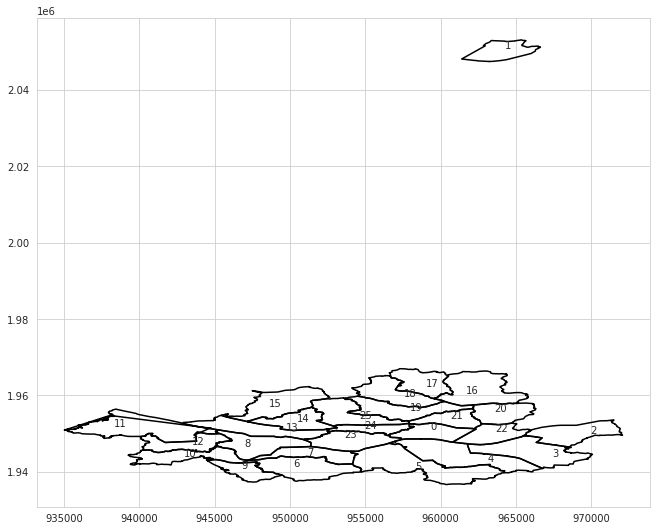

In [64]:
plot_map(sf)

In [ ]:
## SAVE MODEL / LEARNING RATE INFORMATION
from google.colab import files
files.download('./snapshot/best_model.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>